# Validating NRIC/FIN Number

#### Weblink: https://userapps.support.sap.com/sap/support/knowledge/en/2572734

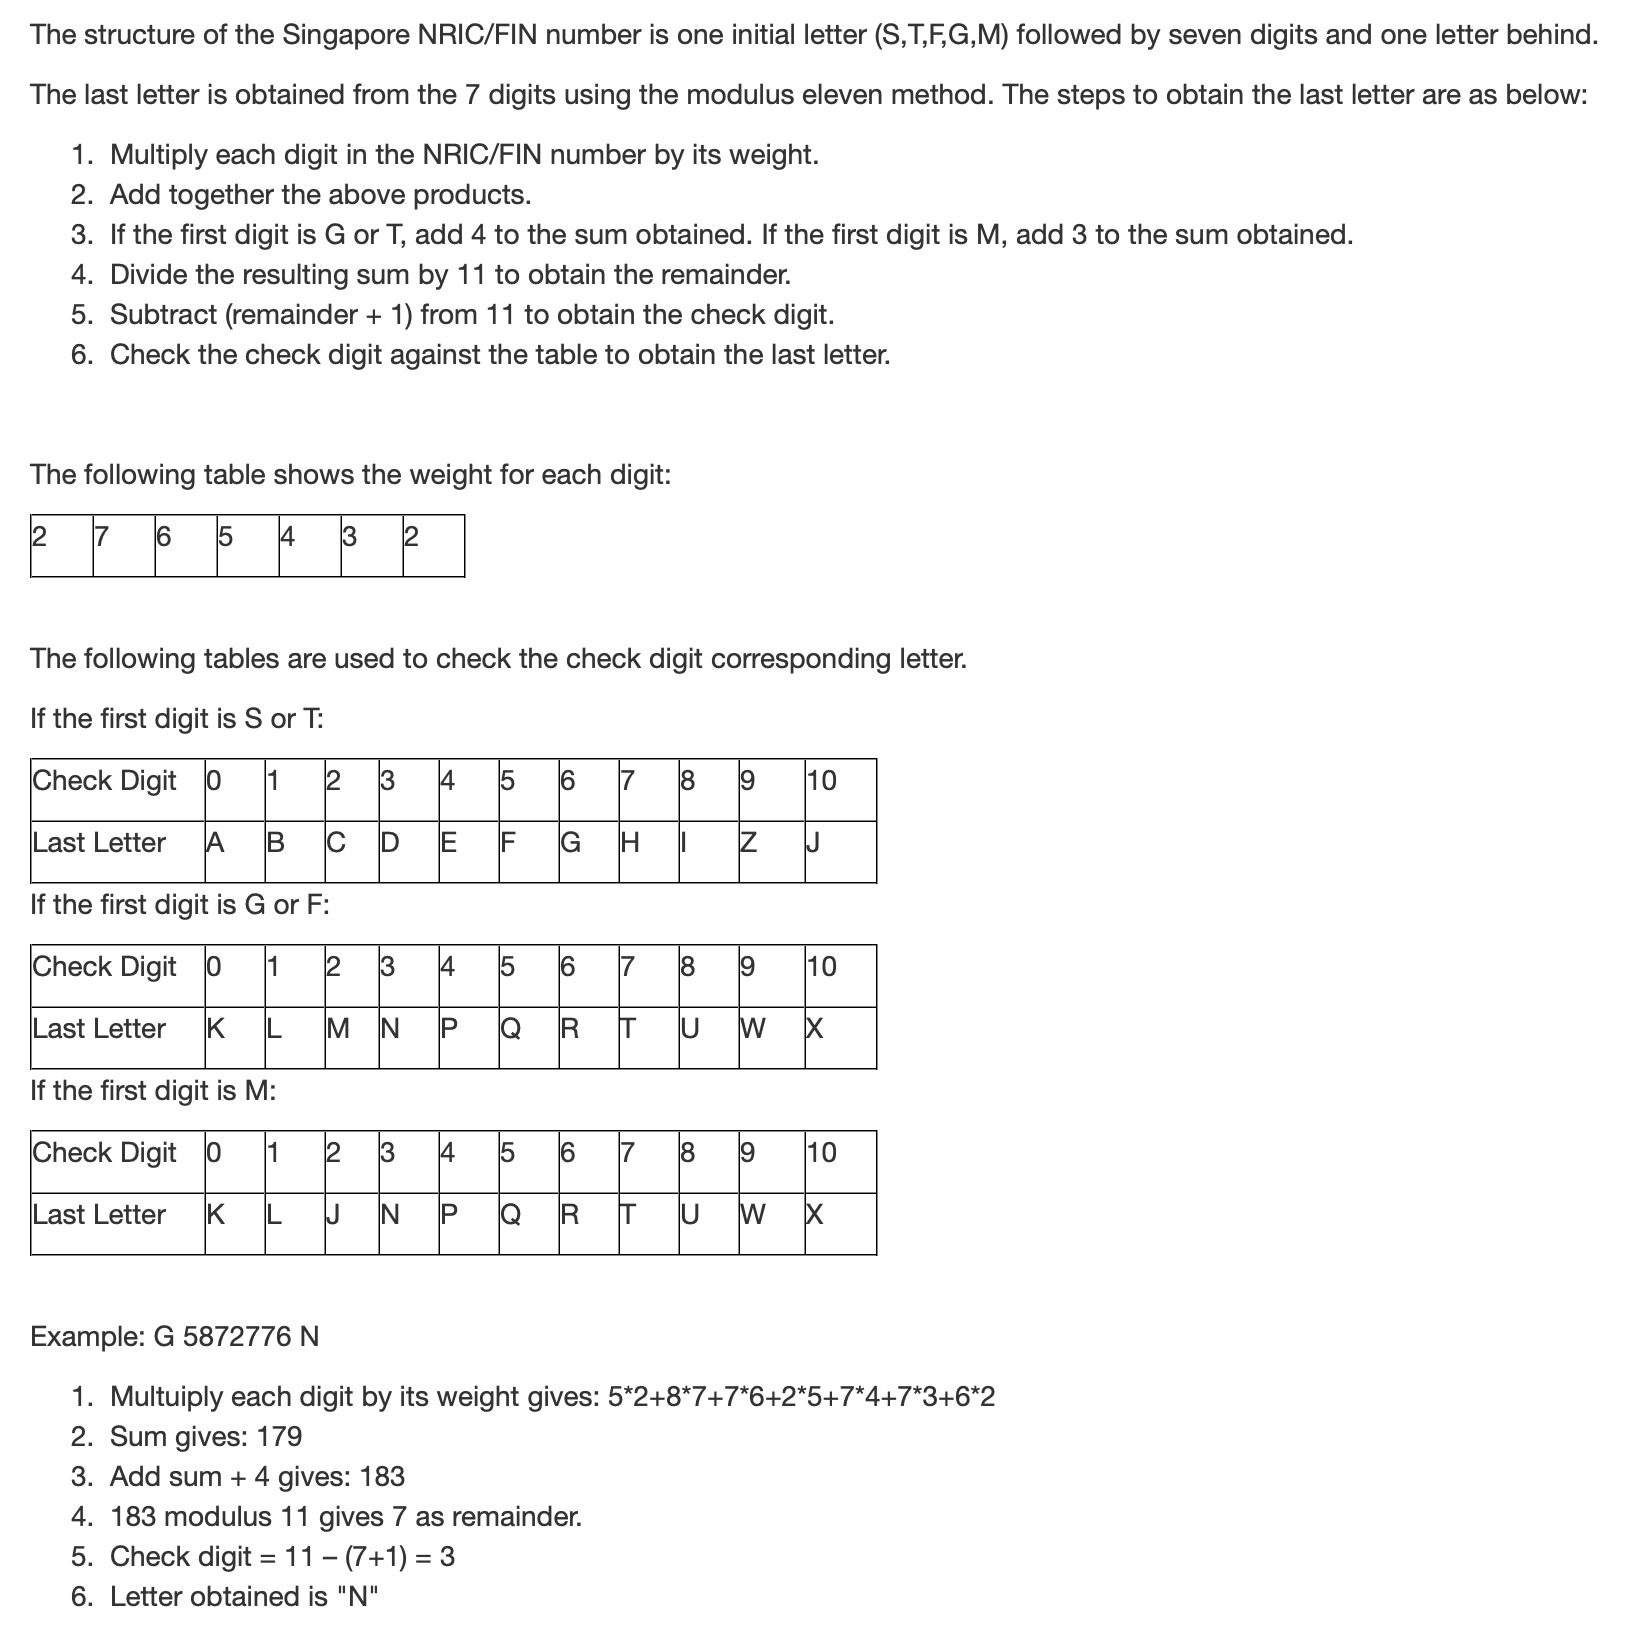

#### Import Libraries

In [ ]:
! pip install schedule  

In [1]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns
import time
import schedule
import os
from IPython.display import clear_output

## 1. Data Collection

#### Function 1: Generate a single random NRIC & country record

In [2]:
def generate_single_record_data():

    random_first_letter = random.choice(string.ascii_letters).upper()
    random_seven_digits_str = "".join(str(random.randint(0, 9)) for _ in range(7))
    random_last_letter = random.choice(string.ascii_letters).upper()
    random_nric = random_first_letter + random_seven_digits_str + random_last_letter
    
    given_country_list = ["Singapore", "Mongolia", "Finland", "Argentina", "Congo"]
    random_country = random.choice(given_country_list)
    
    return random_nric, random_country

#### Function 2: Validate a single NRIC/FIN

In [3]:
def validate_nric(nric_to_validate):
 
    prefix = nric_to_validate[0]
    last_letter = nric_to_validate[-1]
    valid_prefixes = ["S", "T", "F", "G", "M"]
    seven_digits_input = nric_to_validate[1:8]
    
    # Basic check
    if len(nric_to_validate) != 9: # If input is not 9 charecters = Invalid
        return "Invalid"
    elif prefix not in valid_prefixes: # If first letter is not one of the valid prefix = Invalid
        return "Invalid"
    elif not last_letter.isalpha(): # If last letter is not an alplahet = Invalid
        return "Invalid"
    elif not seven_digits_input.isdigit(): # If seven characters in-between are not digits = Invalid
        return "Invalid"


    # Weightage check
    else:
        
        # 1. Append seven_digits_input into a list of integers, then to an array
        seven_digits_input_list = []
        
        for i in seven_digits_input:
            seven_digits_input_list.append(int(i))
        
        seven_digits_input_array = np.array(seven_digits_input_list) 

        # 2. Multiply 'seven_digits_input_array' with 'weight'
        weight = np.array([2,7,6,5,4,3,2]) 
        
        multiplication_of_weight = weight * seven_digits_input_array

        # 3. Sum up the results across the array
        sum_of_multiplication_results = sum(multiplication_of_weight)

        # 4. Add additional values if needed to sum_of_multiplication_results, based on prefix
        if prefix in ["G", "T"]:
            sum_of_multiplication_results = sum_of_multiplication_results + 4
        elif prefix == "M":
            sum_of_multiplication_results = sum_of_multiplication_results + 3

        # 5. Obtain remainder by dividing sum_of_multiplication_results by 11
        remainder = sum_of_multiplication_results % 11

        # 6. Obtain check digit by subtracting (remainder + 1) from 11
        check_digit_index = 11 - (remainder + 1)

        # 7. Match the check_digit against check digit tables 
        first_digit_s_or_t = ["A","B","C","D","E","F","G","H","I","Z","J"]
        first_digit_g_or_f = ["K","L","M","N","P","Q","R","T","U","W","X"]
        first_digit_m = ["K","L","J","N","P","Q","R","T","U","W","X"]
        
        if prefix in ["S", "T"]:
            correct_last_letter = first_digit_s_or_t[check_digit_index]
        elif prefix in ["G", "F"]:
            correct_last_letter = first_digit_g_or_f[check_digit_index]
        else:
            correct_last_letter = first_digit_m[check_digit_index]

        # 8. Check if last_letter that the user input is the same as last_correct_letter
        if last_letter == correct_last_letter:
            return "Valid"
        else:
            return "Invalid"

#### Function 3: Append generated data to dictionary

In [4]:
def append_to_data_dict(data_dict_name, nric, country, validity_status):

    data_dict_name["generated_nric"].append(nric)
    data_dict_name["generated_country"].append(country)
    data_dict_name["validity"].append(validity_status)

#### Function 4: Orchestrate the 3 functions above
1. Generate random NRIC/FIN & country
2. Validate the NRIC/FIN
3. Append the data of NRIC/FIN, country, and validation results to a dictionary

In [5]:
def generate_and_validate_nric(num_to_generate):
 
    # Local dictionary placeholder that stores values. This dictionary resets every time the function is being called
    generated_data_dict_local = {
        "generated_nric": [],
        "generated_country": [],
        "validity": [],
    }

    count = 0
    
    while count < num_to_generate:
        # Function 1: Generate random NRIC/FIN number and country
        random_nric, random_country = generate_single_record_data()
        
        # Function 2: Validate the randomly generated NRIC/FIN
        validity_status = validate_nric(random_nric)
        
        # Function 3: Append all data generated and collected into the local dictionary
        append_to_data_dict(generated_data_dict_local, random_nric, random_country, validity_status)

        # Add 1 to count after each loop
        count += 1
    
    # Return the local dictionary
    return generated_data_dict_local

#### Function 5: Execution and save data to csv
##### Note: This is to mimic real-time data flowing in batches every 5 seconds before being saved in a temporary storage. Stored data will be processed later, instead of real-time processing.

https://www.datacamp.com/tutorial/save-as-csv-pandas-dataframe

https://www.geeksforgeeks.org/python/sleep-in-python/

https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe

https://schedule.readthedocs.io/en/stable/

In [6]:
def job():

    print(f"\n🕒 Starting NRIC generation and validation...")

    # Input the number of NRIC/FIN/Country to generate and validate
    num_to_run = 50000

    # Call Function 4: generate_and_validate_nric to execute and obtain the complete dictionary
    # Additional calls will append data to existing csv file
    nric_results_data = generate_and_validate_nric(num_to_run)

    # Convert the dictionary nric_results_data to a Pandas DataFrame
    nric_validation_list = pd.DataFrame(nric_results_data)

    # Append to CSV and only write the header if the file does not already exist.
    write_header = not os.path.exists("generated_nric_validation_list.csv")
    nric_validation_list.to_csv("generated_nric_validation_list.csv", mode="a", index=False, header=write_header)

    # Confirm save
    print(f"{nric_validation_list.shape[0]} rows saved to generated_nric_validation_list.csv.")

    # Check total rows so far
    total_data_in_csv = pd.read_csv("generated_nric_validation_list.csv")
    current_rows_in_csv = total_data_in_csv.shape[0]
    print(f"Total current rows in file {"generated_nric_validation_list.csv"} is : {current_rows_in_csv}")

# Scheduling a function (job) to run every 5 seconds using the schedule library
schedule.every(5).seconds.do(job)

# Continuous infinite loop to simulate real-time data coming in continuously
while True:
    schedule.run_pending()
    time.sleep(2)


🕒 Starting NRIC generation and validation...
50000 rows saved to generated_nric_validation_list.csv.
Total current rows in file generated_nric_validation_list.csv is : 50000

🕒 Starting NRIC generation and validation...
50000 rows saved to generated_nric_validation_list.csv.
Total current rows in file generated_nric_validation_list.csv is : 100000

🕒 Starting NRIC generation and validation...
50000 rows saved to generated_nric_validation_list.csv.
Total current rows in file generated_nric_validation_list.csv is : 150000

🕒 Starting NRIC generation and validation...
50000 rows saved to generated_nric_validation_list.csv.
Total current rows in file generated_nric_validation_list.csv is : 200000

🕒 Starting NRIC generation and validation...
50000 rows saved to generated_nric_validation_list.csv.
Total current rows in file generated_nric_validation_list.csv is : 250000


KeyboardInterrupt: 

## 2. Batch Processing & Data Storage

https://talent500.com/blog/batch-processing-handling-large-volumes-of-data-in-scheduled-or-periodic-batches/

https://stackoverflow.com/questions/56868137/how-to-change-column-name-of-an-excel-sheet-using-pandas

#### Function 1: Basic data transformation for demonstration purposes

In [7]:
def batch_data_transformation_steps(batch):

    # The things to process or clean will be contained here
    renamed_column_batch = batch.rename(columns={
        "generated_nric": "nric",
        "generated_country": "country"
    })
    
    return renamed_column_batch

#### Function 2: Execute and save data to processed csv
##### Note: This is to simulate saving processed data to a database

In [8]:
def batch_processing(input_file_path="generated_nric_validation_list.csv",
                     output_file_path="processed_nric_validation_list.csv",
                     batch_size=50000):
    
    print(f"Starting processing of '{input_file_path}' to '{output_file_path}'...\n")

    write_header_for_this_batch = True
    total_rows_processed = 0  # Track total rows processed
    all_batches = []  # To collect remaining data that wasn't processed

    for batch in pd.read_csv(input_file_path, chunksize=batch_size):
        print(f"  Processing a batch with {batch.shape[0]} rows...")
        total_rows_processed += batch.shape[0]

        # Apply transformation
        transformed_batch = batch_data_transformation_steps(batch)

        # Save the processed batch to output file
        transformed_batch.to_csv(output_file_path, header=write_header_for_this_batch, mode="a", index=False)
        write_header_for_this_batch = False  # Only write header once

        time.sleep(1)

    print(f"\n✅ {total_rows_processed} rows processed and transferred to '{output_file_path}'.")

    # Optional: remove processed rows by keeping only remaining rows
    # Since all rows were processed in this case, just empty the original file (keeping headers for consistency)
    empty_df = pd.DataFrame(columns=["generated_nric", "generated_country", "validity"])
    empty_df.to_csv(input_file_path, index=False)

    print(f"🧹 Source file {input_file_path}' cleared after processing.")

    
batch_processing()

Starting processing of 'generated_nric_validation_list.csv' to 'processed_nric_validation_list.csv'...

  Processing a batch with 50000 rows...
  Processing a batch with 50000 rows...
  Processing a batch with 50000 rows...
  Processing a batch with 50000 rows...
  Processing a batch with 50000 rows...

✅ 250000 rows processed and transferred to 'processed_nric_validation_list.csv'.
🧹 Source file generated_nric_validation_list.csv' cleared after processing.


#### Create bar chart from processed data

https://blog.dailydoseofds.com/p/clear-cell-output-in-jupyter-notebook

/var/folders/pl/l5m8srb54vb0hqlcp588dpr00000gn/T/ipykernel_10967/3446552287.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='invalid_count', data=invalid_counts_by_country, palette='plasma')


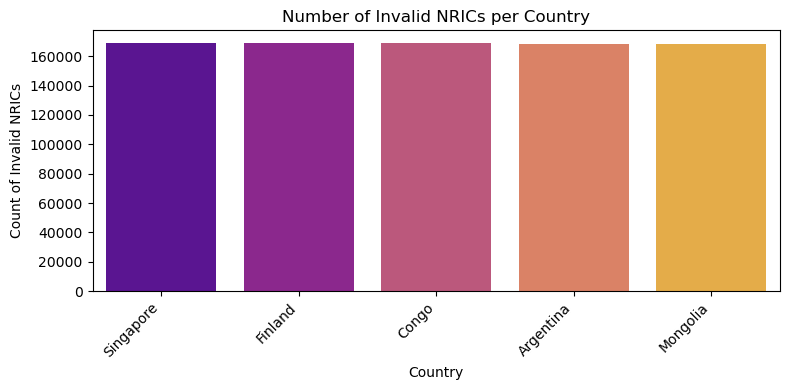

/var/folders/pl/l5m8srb54vb0hqlcp588dpr00000gn/T/ipykernel_10967/3446552287.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='validity_numeric', data=proportion_valid, palette='coolwarm')



--- Plotting Proportion of Valid NRICs per Country (Optional) ---


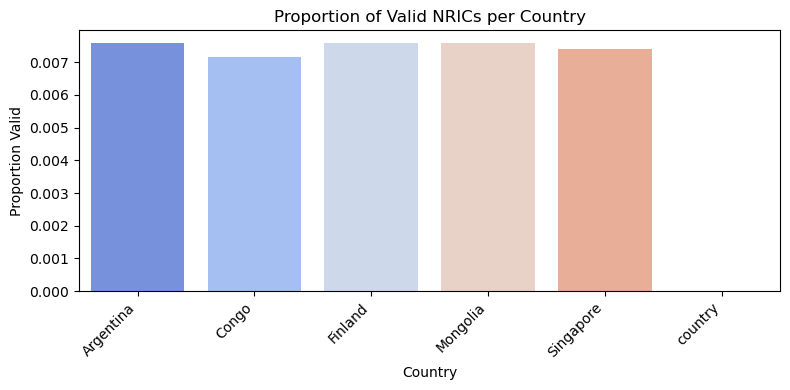

In [9]:
# Load processed data
processed_data_in_csv = pd.read_csv("processed_nric_validation_list.csv")

# Simulate loading effect
print("Plotting invalid NRICs or FINs by country ...\n")
time.sleep(1)
clear_output(wait=True)
print("Plotting invalid NRICs or FINs by country ....\n")
time.sleep(1)
clear_output(wait=True)
print("Plotting invalid NRICs or FINs by country .....\n")
time.sleep(1)
clear_output(wait=True)
print("Plotting invalid NRICs or FINs by country ......\n")
time.sleep(1)
clear_output(wait=True)

# Filter for invalid and valid entries
invalid_nrics = processed_data_in_csv.query("validity == 'Invalid'")

# Count invalid occurrences by country
invalid_counts_by_country = invalid_nrics['country'].value_counts().reset_index()
invalid_counts_by_country.columns = ['country', 'invalid_count']  # Rename columns

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='country', y='invalid_count', data=invalid_counts_by_country, palette='plasma')
plt.title('Number of Invalid NRICs per Country')
plt.xlabel('Country')
plt.ylabel('Count of Invalid NRICs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optional: Bar Chart for Proportion of Valid NRICs per Country
print("\n--- Plotting Proportion of Valid NRICs per Country (Optional) ---")
processed_data_in_csv['validity_numeric'] = processed_data_in_csv['validity'].apply(lambda x: 1 if x == 'Valid' else 0)

proportion_valid = processed_data_in_csv.groupby('country')['validity_numeric'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='country', y='validity_numeric', data=proportion_valid, palette='coolwarm')
plt.title('Proportion of Valid NRICs per Country')
plt.xlabel('Country')
plt.ylabel('Proportion Valid')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Create Tableau dashboard from processed data

https://prod-apsoutheast-b.online.tableau.com/#/site/jackchonghengg-12406a8306/views/MetricsfromNRICFINGeneratorValidator/Dashboard1?:iid=2

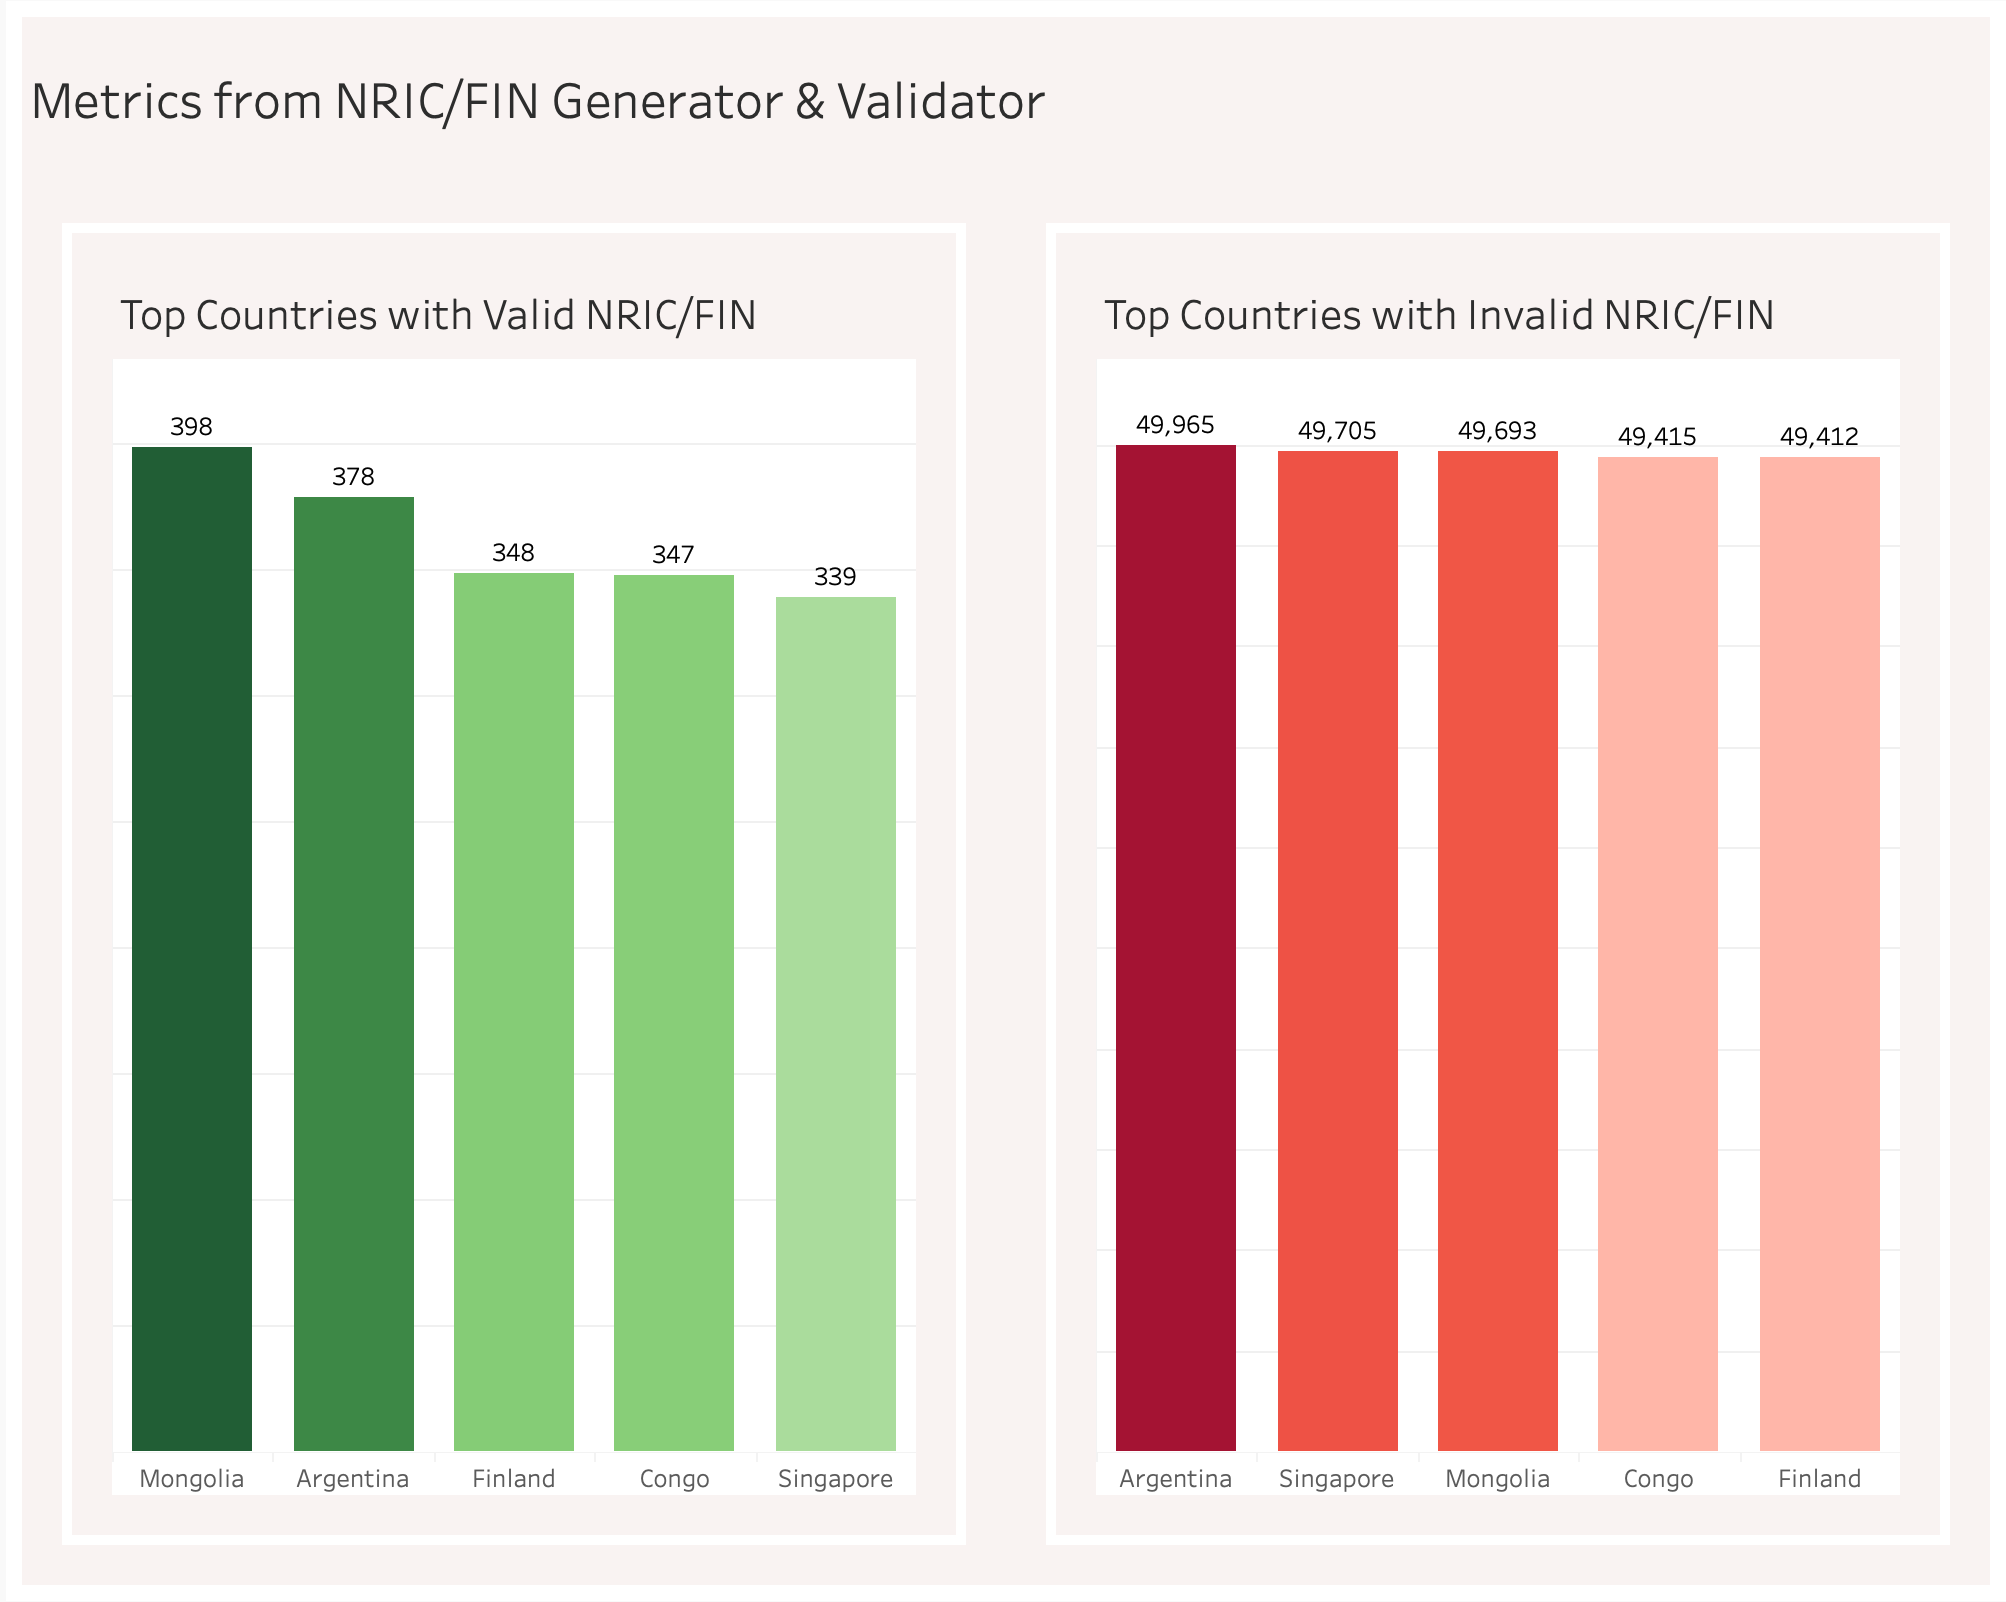

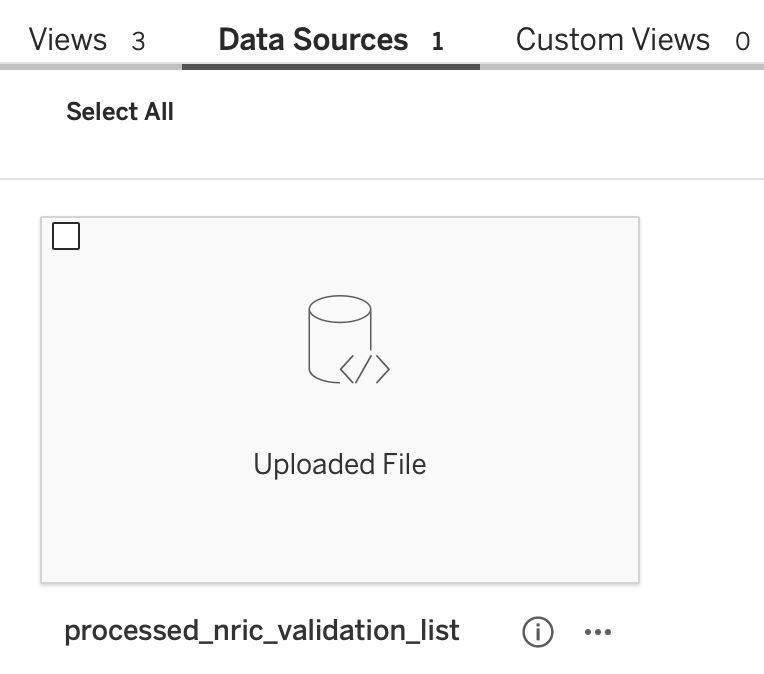